In [1]:
%matplotlib inline
%autosave 20
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from datetime import datetime
import nltk
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from bs4 import BeautifulSoup
import itertools
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from textblob import Word
import re
from autocorrect import spell
from sqlalchemy import create_engine

Autosaving every 20 seconds


In [2]:
url="https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD"
DATA = pd.read_csv(url)
DATA.shape

(1104472, 18)

Changing Column Names and Creating Year, Month, and Day Variables

In [3]:
DATA.rename(columns={"Date received": "DATE","Product":"PRODUCT", "Sub-product":"SUB_PRODUCT", "Issue":"ISSUE", "Sub-issue":"SUB_ISSUE",
"Consumer complaint narrative": "NARRATIVE","Company public response": "COMP_PUB_RESPONSE", "ZIP code":"ZIP", 
"Consumer consent provided?":"CONSENT","Submitted via":"VIA", "Company response to consumer":"COMPANY_RESPONSE",
                     "Timely response?": "TIMELY_RESPONSE", "Consumer disputed?":"CONSUMER_DISPUTED",
"Complaint ID":"COMPLAINT_ID"}, inplace=True)
DATA.DATE=pd.to_datetime(DATA.DATE)
DATA.sort_values(by=["DATE"], inplace=True)
DATA["YEAR"]=DATA.DATE.dt.year
DATA["Month"]=DATA.DATE.dt.month
DATA["DAY"]=DATA.DATE.dt.day
DATA.shape

(1104472, 21)

In [4]:
DATA.PRODUCT.value_counts(dropna=False)

Mortgage                                                                        262351
Debt collection                                                                 212590
Credit reporting, credit repair services, or other personal consumer reports    143898
Credit reporting                                                                140433
Credit card                                                                      89191
Bank account or service                                                          86206
Student loan                                                                     45691
Consumer Loan                                                                    31605
Credit card or prepaid card                                                      30598
Checking or savings account                                                      25773
Vehicle loan or lease                                                             7518
Money transfer, virtual currency, or money 

# Reorganizing Product Types to Get a More Balanced Classification Problem

In [5]:
DATA.loc[DATA.PRODUCT=="Payday loan, title loan, or personal loan", "PRO_TYPE"]="LOAN_RELATED"
DATA.loc[DATA.PRODUCT=="Payday loan", "PRO_TYPE"]="LOAN_RELATED"
DATA.loc[DATA.PRODUCT=="Vehicle loan or lease","PRO_TYPE"]="LOAN_RELATED"
DATA.loc[DATA.PRODUCT=="Consumer Loan","PRO_TYPE"]="LOAN_RELATED"
DATA.loc[DATA.PRODUCT=="Student loan","PRO_TYPE"]="LOAN_RELATED"

DATA.loc[DATA.PRODUCT=="Credit reporting, credit repair services, or other personal consumer reports","PRO_TYPE"]="CREDIT_REPORT"
DATA.loc[DATA.PRODUCT=="Credit reporting", "PRO_TYPE"]="CREDIT_REPORT"

DATA.loc[DATA.PRODUCT=="Credit card","PRO_TYPE"]="CARD_RELATED"
DATA.loc[DATA.PRODUCT=="Credit card or prepaid card", "PRO_TYPE"]="CARD_RELATED"
DATA.loc[DATA.PRODUCT=="Prepaid card", "PRO_TYPE"]="CARD_RELATED"

DATA.loc[DATA.PRODUCT=="Mortgage", "PRO_TYPE"]="MORTGAGE"
DATA.loc[(DATA.PRODUCT=="Debt collection") & (DATA.SUB_PRODUCT=="Mortgage"), "PRO_TYPE"]="MORTGAGE"

DATA.loc[DATA.PRODUCT=="Bank account or service", "PRO_TYPE"]="SERVICE_RELATED"
DATA.loc[DATA.PRODUCT=="Virtual currency", "PRO_TYPE"]="SERVICE_RELATED"
DATA.loc[DATA.PRODUCT=="Other financial service", "PRO_TYPE"]="SERVICE_RELATED"
DATA.loc[DATA.PRODUCT=="Money transfers", "PRO_TYPE"]="SERVICE_RELATED"
DATA.loc[DATA.PRODUCT=="Money transfer, virtual currency, or money service", "PRO_TYPE"]="SERVICE_RELATED"
DATA.loc[DATA.PRODUCT=="Checking or savings account", "PRO_TYPE"]="SERVICE_RELATED"

DATA.loc[DATA.PRODUCT=="Debt collection", "PRO_TYPE"]="DEBT_COLLECTION"
DATA.PRO_TYPE.value_counts(dropna=False)

CREDIT_REPORT      284331
MORTGAGE           262351
DEBT_COLLECTION    212590
SERVICE_RELATED    125572
CARD_RELATED       123608
LOAN_RELATED        96020
Name: PRO_TYPE, dtype: int64

Getting Year Dummies

In [6]:
for i in pd.get_dummies(DATA.YEAR,prefix="dum").columns: # No NaNs
    DATA[i]=pd.get_dummies(DATA.YEAR, prefix="dum")[i]

In [7]:
# Saving the full data before we start working on narrative-only part of the full dataset
DATA.to_csv("DATA_8_23_18.csv")

In [2]:
DATA=pd.read_csv("DATA_8_23_18.csv")
DATA=DATA.drop("Unnamed: 0", axis=1)
print(DATA.shape)
DATA.head(3)

C:\Users\Turgut\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6,12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1104472, 30)


,DATE,PRODUCT,SUB_PRODUCT,ISSUE,SUB_ISSUE,NARRATIVE,COMP_PUB_RESPONSE,Company,State,ZIP,...,DAY,PRO_TYPE,dum_2011,dum_2012,dum_2013,dum_2014,dum_2015,dum_2016,dum_2017,dum_2018
0,2011-12-01,Mortgage,Reverse mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,WELLS FARGO & COMPANY,OH,43209,...,1,MORTGAGE,1,0,0,0,0,0,0,0
1,2011-12-01,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,NY,14224,...,1,CARD_RELATED,1,0,0,0,0,0,0,0
2,2011-12-01,Credit card,NaN,Other,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,90032,...,1,CARD_RELATED,1,0,0,0,0,0,0,0


In [3]:
# Creating a subset of full data that contains narratives
DATA_N=DATA[DATA.NARRATIVE.notnull()]
DATA_N.shape

(314136, 30)

# Cleaning the Narratives

In [4]:
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE'].apply(lambda x: " ".join(x.replace("XXXX", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("XX/XX/", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("(  )", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("  ", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace(",,", ",") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("...", ".") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("\r\n", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("//", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace("(", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace(")", "") for x in x.split()))
DATA_N['NARRATIVE_CLEAN']=DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.replace(",", "") for x in x.split()))

C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

# Getting Sentiments BEFORE Removing Sentiment-related Words

In [5]:
DATA_N['SENTIMENT_BEFORE_LEM'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda i: TextBlob(i).sentiment)
DATA_N['SENTIMENT_BEFORE_LEM_P'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda i: TextBlob(i).sentiment.polarity)
DATA_N['SENTIMENT_BEFORE_LEM_S'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda i: TextBlob(i).sentiment.subjectivity)

C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [6]:
# Lower all the letters
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#Remove Punctuation
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].str.replace('[^\w\s]','')
#Removal of Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Excluding short words--one letter
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x for x in x.split() if len(x) >2))
# Removing erroneously combined words by checking word length
DATA_N['NARRATIVE_CLEAN']=DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join(x for x in x.split() if len(x) <15))
#Lemmatization--
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#stemmatization
DATA_N['NARRATIVE_CLEAN'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: " ".join([PorterStemmer().stem(word) for word in x.split()]))
#remove all numbers
DATA_N['NARRATIVE_CLEAN']=DATA_N['NARRATIVE_CLEAN'].str.replace('\d+', '')
DATA_N['NARRATIVE_CLEAN'].head(8)

C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

369808    debt collector call numer time privat number c...
369811    compani continu report credit report sent lett...
369813    mail sever complaint differ address compani we...
369817    reach howev never got respons unfortun victim ...
369820    mel harri assoc use decept collect practic att...
369827    receiv letter pioneer credit recoveri claim ow...
369832    credit card account holder chase card card acc...
369838    fell behind payment back  follow realli unreas...
Name: NARRATIVE_CLEAN, dtype: object

# Tokenization

We will work on narratives so it is more efficient to work only on a subset of overall dataset, which contains narratives.

In [7]:
DATA_N["TOKENS"]=DATA_N['NARRATIVE_CLEAN'].apply(word_tokenize)
DATA_N["TOKENS"].head()

C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


369808    [debt, collector, call, numer, time, privat, n...
369811    [compani, continu, report, credit, report, sen...
369813    [mail, sever, complaint, differ, address, comp...
369817    [reach, howev, never, got, respons, unfortun, ...
369820    [mel, harri, assoc, use, decept, collect, prac...
Name: TOKENS, dtype: object

In [9]:
#Save tokens as pickle.
joblib.dump(DATA_N.TOKENS, "DATA_N_TOKENS.joblib")

['DATA_N_TOKENS.joblib']

# Adding more features- word count, character count, numeric count, and uppercase letters

In [8]:
DATA_N['WORD_COUNT'] = DATA_N['NARRATIVE_CLEAN'].apply(lambda x: len(str(x).split(" ")))
DATA_N['NUMERIC_COUNT'] = DATA_N['NARRATIVE'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
DATA_N['CHAR_COUNT'] = DATA_N["NARRATIVE_CLEAN"].str.len() ## this also includes spaces
DATA_N['UPPER']= DATA_N['NARRATIVE'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
DATA_N["EXCLAMATION_COUNT"]=DATA_N['NARRATIVE'].apply(lambda x: x.count('!'))
DATA_N[['WORD_COUNT', 'NUMERIC_COUNT', 'CHAR_COUNT', 'UPPER', "EXCLAMATION_COUNT"]].head(3)

C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

,WORD_COUNT,NUMERIC_COUNT,CHAR_COUNT,UPPER,EXCLAMATION_COUNT
369808,45,1,265,3,0
369811,41,0,262,28,4
369813,70,0,454,9,0


In [13]:
type(DATA_N["TOKENS"][369808][2])

str

In [11]:
DATA_N["TOKENS"][369808][0]

'debt'

In [14]:
# Save as a csv file
DATA_N.to_csv("DATA_N_8_23_18.csv")

In [12]:
DATA_N.shape

(314136, 40)

Saving narrative-only data

In [33]:
DATA_N=DATA[DATA.NARRATIVE.notnull()]
DATA_N.to_csv("DATA_N_8_23_18.csv")

In [13]:
DATA_N.NARRATIVE_CLEAN.head()

369808    debt collector call numer time privat number c...
369811    compani continu report credit report sent lett...
369813    mail sever complaint differ address compani we...
369817    reach howev never got respons unfortun victim ...
369820    mel harri assoc use decept collect practic att...
Name: NARRATIVE_CLEAN, dtype: object

In [22]:
DATA_N["TOKENS"].head()

369808    [debt, collector, call, numer, time, privat, n...
369811    [compani, continu, report, credit, report, sen...
369813    [mail, sever, complaint, differ, address, comp...
369817    [reach, howev, never, got, respons, unfortun, ...
369820    [mel, harri, assoc, use, decept, collect, prac...
Name: TOKENS, dtype: object

In [15]:
type(DATA_N["TOKENS"][369808])

list

In [22]:
DATA.to_csv("DATA_7_7_18.csv")

In [1]:
%matplotlib inline
%autosave 20
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

DATA_N=pd.read_csv("DATA_N_7_7_18.csv",low_memory=False)
DATA_N=DATA_N.drop("Unnamed: 0", axis=1)
DATA_N.shape

Autosaving every 20 seconds


(299516, 40)

# Analysis

In [24]:
DATA_N['category_id'] = DATA_N['PRO_TYPE'].factorize()[0]
category_id_df = DATA_N[['PRO_TYPE', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'PRO_TYPE']].values)
DATA_N.head()

C:\Users\Turgut\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DATE,PRODUCT,SUB_PRODUCT,ISSUE,SUB_ISSUE,NARRATIVE,COMP_PUB_RESPONSE,Company,State,ZIP,...,SENTIMENT_BEFORE_LEM,SENTIMENT_BEFORE_LEM_P,SENTIMENT_BEFORE_LEM_S,TOKENS,WORD_COUNT,NUMERIC_COUNT,CHAR_COUNT,UPPER,EXCLAMATION_COUNT,category_id
369808,2015-03-19,Debt collection,Payday loan,Taking/threatening an illegal action,Threatened arrest/jail if do not pay,This debt collector has called me numerous tim...,NaN,"National Principal Group, LLC",FL,326XX,...,"(-0.017857142857142856, 0.39732142857142855)",-0.017857,0.397321,"[debt, collector, call, numer, time, privat, n...",45,1,265,3,0,0
369811,2015-03-19,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,This company continues to report on my credit ...,NaN,"Pinnacle Credit Services, LLC",TX,775XX,...,"(0.0, 0.0)",0.000000,0.000000,"[compani, continu, report, credit, report, sen...",41,0,262,28,4,0
369813,2015-03-19,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,I mailed off several complaints to different a...,Company believes it acted appropriately as aut...,"CONSUMER PORTFOLIO SERVICES, INC.",MD,20703,...,"(-0.12999999999999998, 0.34)",-0.130000,0.340000,"[mail, sever, complaint, differ, address, comp...",70,0,454,9,0,0
369817,2015-03-19,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,"Reached out to them however, never got a respo...",Company believes it acted appropriately as aut...,FC HoldCo LLC,MD,20703,...,"(-0.21666666666666665, 0.3666666666666667)",-0.216667,0.366667,"[reach, howev, never, got, respons, unfortun, ...",63,0,412,7,0,0
369820,2015-03-19,Credit card,NaN,Other,NaN,Mel S. Harris & assoc. used deceptive collecti...,NaN,"Mel S. Harris and Associates, LLC",NY,140XX,...,"(0.12760416666666669, 0.37512019230769234)",0.127604,0.375120,"[mel, harri, assoc, use, decept, collect, prac...",179,0,1130,19,1,1


#Saving tokens, pandas convert evertying to string and when you reload your data later you have '[' character as a part of token. To avoid that, I load tokens I saved as part of joblib process then, attach it to the data frame.

In [34]:
TOKEN = joblib.load("DATA_N_TOKENS.joblib")
TOKEN=pd.DataFrame(TOKEN)
TOKEN=TOKEN.reset_index(drop=True)
TOKEN.shape

(314136, 1)

In [17]:
TOKEN.iloc[0,0][0]

NameError: name 'TOKEN' is not defined

In [36]:
DATA_N.TOKENS=TOKEN

C:\Users\Turgut\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
DATA_N.TOKENS

369808     [debt, collector, call, numer, time, privat, n...
369811     [compani, continu, report, credit, report, sen...
369813     [mail, sever, complaint, differ, address, comp...
369817     [reach, howev, never, got, respons, unfortun, ...
369820     [mel, harri, assoc, use, decept, collect, prac...
369827     [receiv, letter, pioneer, credit, recoveri, cl...
369832     [credit, card, account, holder, chase, card, c...
369838     [fell, behind, payment, back, follow, realli, ...
369839                                  [item, report, fals]
369842     [appli, extra, loan, payment, princip, balanc,...
369846     [compani, call, human, resourc, person, work, ...
369848     [approv, trial, modif, select, portfolio, serv...
369860     [receiv, letter, dynam, recoveri, today, conce...
369867     [recent, close, paid, citizen, bank, credit, c...
369870     [late, earli, receiv, sever, voic, messag, ema...
369871     [made, payment, loan, appli, financ, charg, pr...
369874     [appli, credi

In [21]:
DATA_N.loc[369808,'TOKENS'][0]

'debt'

# Vectorization

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', lowercase=False, max_features=5000,
        preprocessor=' '.join, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(DATA_N.TOKENS).toarray()
labels = DATA_N.category_id
features.shape

(314136, 5000)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, DATA_N.index,  random_state=0)

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_hat_train_log = logreg.predict(X_train)
print( "Train Accuracy:",(metrics.accuracy_score(y_train, y_hat_train_log)))

y_hat_test_log = logreg.predict(X_test)
print( 'Test Accuracy:',(metrics.accuracy_score(y_test, y_hat_test_log)))

Train Accuracy: 0.8670699840186612
Test Accuracy: 0.8547790435235513


In [28]:
SVC = LinearSVC()
SVC.fit(X_train, y_train)
y_hat_train_SVC = SVC.predict(X_train)
print( "Train Accuracy:",(metrics.accuracy_score(y_train, y_hat_train_SVC)))
y_hat_test_SVC = SVC.predict(X_test)
print( 'Test Accuracy:',(metrics.accuracy_score(y_test, y_hat_test_SVC)))

Train Accuracy: 0.8727302824254463
Test Accuracy: 0.8534265413706166


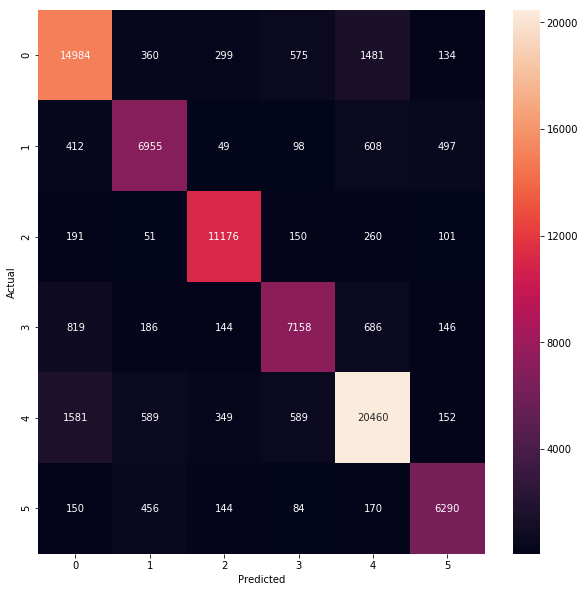

In [29]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_hat_test_SVC)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            #xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_hat_test_SVC, target_names=DATA_N['PRO_TYPE'].unique()))

                 precision    recall  f1-score   support

DEBT_COLLECTION       0.83      0.84      0.83     17833
   CARD_RELATED       0.81      0.81      0.81      8619
       MORTGAGE       0.92      0.94      0.93     11929
   LOAN_RELATED       0.83      0.78      0.80      9139
  CREDIT_REPORT       0.86      0.86      0.86     23720
SERVICE_RELATED       0.86      0.86      0.86      7294

    avg / total       0.85      0.85      0.85     78534



In [11]:
%xdel TOKEN

In [12]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('features', 11980640112),
 ('X_train', 8985480112),
 ('X_test', 2995160112),
 ('DATA_N', 1204361736),
 ('y_train', 3594216),
 ('labels', 2396232),
 ('indices_train', 1797120),
 ('y_test', 1198088),
 ('indices_test', 599056),
 ('TfidfVectorizer', 1464),
 ('CountVectorizer', 1056),
 ('LinearSVC', 1056),
 ('LogisticRegression', 1056),
 ('StandardScaler', 1056),
 ('TfidfTransformer', 1056),
 ('XGBClassifier', 1056),
 ('category_id_df', 537),
 ('category_to_id', 368),
 ('id_to_category', 368),
 ('confusion_matrix', 136),
 ('cross_val_score', 136),
 ('train_test_split', 136),
 ('metrics', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('stats', 80),
 ('tfidf', 56)]